In [ ]:
# === Product Purchase Prediction with GraphXAI ===
# Full Pipeline: Load filtered Taobao graph (2017-11-28), train GCN, explain predictions

import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from graphxai.gnn_models.node_classification import GCN
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from datetime import datetime

# === Step 1: Load preprocessed graph for one day ===
data = torch.load('graph_2017-11-28.pt')

# === Step 2: Setup node counts and offsets ===
num_users = data['user'].num_nodes
num_items = data['item'].num_nodes
num_nodes = num_users + num_items

# Offset item index
user_item_ei = data['user', 'item'].edge_index.clone()
user_item_ei[1] += num_users  # offset items

# === Step 3: Create node features and labels ===
x = torch.randn((num_nodes, 32))
data.x = x

# Label 1 = Buy, 0 = else
y = torch.zeros(num_nodes, dtype=torch.long)
buy_mask = (data['user', 'item'].behavior == 2)
buy_items = user_item_ei[1, buy_mask]
y[buy_items] = 1
data.y = y
data.edge_index = user_item_ei

# === Step 4: Train/test split on item nodes only ===
item_idx = torch.arange(num_users, num_nodes)
item_labels = y[item_idx]

train_idx_np, test_idx_np = train_test_split(
    item_idx.cpu().numpy(),
    test_size=0.3,
    stratify=item_labels.cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx_np)
test_idx = torch.tensor(test_idx_np)

# === Step 5: Setup model ===
num_classes = len(torch.unique(y))
model = GCN(hidden_channels=64, input_feat=x.size(1), classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
train_idx = train_idx.to(device)
test_idx = test_idx.to(device)

# === Step 6: Training setup ===
class_weights = compute_class_weight('balanced', classes=np.unique(y.cpu()), y=y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Step 7: Train the model ===
print("Start training...")
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(x, data.edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        pred = out[test_idx].argmax(dim=1)
        acc = (pred == y[test_idx]).float().mean().item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")


Start training...
Epoch 20, Loss: 0.6468, Test Acc: 0.3185
Epoch 40, Loss: 0.5922, Test Acc: 0.4640
Epoch 60, Loss: 0.5617, Test Acc: 0.5539
Epoch 80, Loss: 0.5393, Test Acc: 0.6801
Epoch 100, Loss: 0.5216, Test Acc: 0.7289
Epoch 120, Loss: 0.5072, Test Acc: 0.7636
Epoch 140, Loss: 0.4950, Test Acc: 0.7906
Epoch 160, Loss: 0.4839, Test Acc: 0.8041
Epoch 180, Loss: 0.4727, Test Acc: 0.8171
Epoch 200, Loss: 0.4654, Test Acc: 0.8269


In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from graphxai.explainers import GradExplainer, GNNExplainer, GraphLIME, PGMExplainer
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from graphxai.utils import Explanation
# === Step 8: Pick one correctly predicted Buy node to explain ===
model.eval()
out = model(x, data.edge_index)
pred = out.argmax(dim=1)

# Cari node Buy yang diprediksi benar
correct_buy = test_idx[(pred[test_idx] == y[test_idx]) & (y[test_idx] == 1)]

if len(correct_buy) == 0:
    print("No correctly predicted Buy node found.")
    exit()

node_to_explain = random.choice(correct_buy.tolist())
print(f"Selected node {node_to_explain} for explanation.")

# === Step 9: Subgraph Extraction (2-hop neighborhood) ===
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=node_to_explain,
    num_hops=2,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=num_nodes
)

sub_x = x[subset]
sub_y = y[subset]

def convert_to_full_explanation(exp, node_idx, subset, sub_edge_index, mapping, edge_mask, data):
    full_node_imp = torch.zeros(data.num_nodes)
    if exp.node_imp is not None:
        for i, imp in enumerate(exp.node_imp):
            if i < len(subset):
                full_node_imp[subset[i]] = imp

    # Langkah 1: buat Explanation tanpa enc_subgraph
    full_exp = Explanation(
        node_imp=full_node_imp,
        node_idx=node_idx
    )

    # Langkah 2: tambahkan enc_subgraph setelahnya
    full_exp.enc_subgraph = Data(
        x=data.x[subset],
        edge_index=sub_edge_index,
        y=data.y[subset]
    )

    return full_exp

# Helper functions for evaluation
def graph_exp_acc(gt_exp, gen_exp):
    gt_nodes = torch.where(gt_exp.node_imp > 0)[0]
    pred_nodes = torch.where(gen_exp.node_imp > 0)[0]
    intersect = set(gt_nodes.tolist()) & set(pred_nodes.tolist())
    union = set(gt_nodes.tolist()) | set(pred_nodes.tolist())
    if len(union) == 0:
        return 1.0 if len(intersect) == 0 else 0.0
    return len(intersect) / len(union)

def graph_exp_faith(exp, data):
    if exp.node_imp is None:
        return 0.0
    k = int(len(exp.node_imp) * 0.25)
    top_nodes = exp.node_imp.topk(k).indices
    mask_x = data.x.clone()
    zero_nodes = list(set(range(data.x.shape[0])) - set(top_nodes.tolist()))
    mask_x[zero_nodes] = 0
    out_original = model(data.x, data.edge_index)[exp.node_idx]
    out_masked = model(mask_x, data.edge_index)[exp.node_idx]
    return 1 - torch.norm(out_original - out_masked, p=1).item()

# === Step 10: Run 4 Explainers ===
explainers = {
    'GradExplainer': GradExplainer,
    'GNNExplainer': GNNExplainer,
    'GraphLIME': GraphLIME,
    'PGMExplainer': PGMExplainer
}

results = {}
full_explanations = {}

os.makedirs('explanation_imgs', exist_ok=True)

for name, Explainer in explainers.items():
    print(f"Running {name}...")
    explainer = Explainer(model=model, criterion=criterion)
    exp = explainer.get_explanation_node(
        node_idx=mapping.item(),  # node in subgraph
        x=sub_x,
        edge_index=sub_edge_index,
        forward_kwargs={}
    )
    full_exp = convert_to_full_explanation(
        exp,
        node_idx=node_to_explain,
        subset=subset,
        sub_edge_index=sub_edge_index,
        mapping=mapping,
        edge_mask=None,
        data=data
    )
    full_explanations[name] = full_exp

    gea = graph_exp_acc(full_exp, Data(x=sub_x, edge_index=sub_edge_index, y=sub_y))
    gef = graph_exp_faith(full_exp, Data(x=sub_x, edge_index=sub_edge_index, y=sub_y))
    results[name] = {'GEA': gea, 'GEF': gef}

    del exp
    torch.cuda.empty_cache()

# === Step 11: Save GEA & GEF Results to CSV ===
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv("explanation_metrics.csv")
print("\nSaved explanation_metrics.csv")

# === Step 12: Visualize All Explanations ===
fig, ax = plt.subplots(1, 4, figsize=(24, 5))

for name, Explainer in explainers.items():
    ...
    full_explanations[name] = full_exp

    gef = graph_exp_faith(full_exp, Data(x=sub_x, edge_index=sub_edge_index, y=sub_y))
    results[name] = {'GEF': gef}


plt.tight_layout()
plt.savefig(f"explanation_imgs/all_explainers_node{node_to_explain}.png")
plt.show()

# === Final Output ===
print("\n=== Explanation Metrics ===")
print(metrics_df)


Selected node 696991 for explanation.
Running GradExplainer...


AttributeError: 'GlobalStorage' object has no attribute 'node_imp'

In [ ]:
# === Product Purchase Prediction & Explanation with GraphXAI ===

import os
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from graphxai.gnn_models.node_classification import GCN
from graphxai.explainers import GradExplainer, GNNExplainer, GraphLIME, PGMExplainer
from graphxai.utils import Explanation
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph

# === Step 1: Load Graph Data ===
data = torch.load('graph_2017-11-28.pt')

num_users = data['user'].num_nodes
num_items = data['item'].num_nodes
num_nodes = num_users + num_items

user_item_ei = data['user', 'item'].edge_index.clone()
user_item_ei[1] += num_users

x = torch.randn((num_nodes, 32))
data.x = x

y = torch.zeros(num_nodes, dtype=torch.long)
buy_mask = (data['user', 'item'].behavior == 2)
buy_items = user_item_ei[1, buy_mask]
y[buy_items] = 1
data.y = y
data.edge_index = user_item_ei

# === Step 2: Train/Test Split (on item nodes only) ===
item_idx = torch.arange(num_users, num_nodes)
item_labels = y[item_idx]

train_idx_np, test_idx_np = train_test_split(
    item_idx.cpu().numpy(),
    test_size=0.3,
    stratify=item_labels.cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx_np)
test_idx = torch.tensor(test_idx_np)

# === Step 3: Setup Model ===
num_classes = len(torch.unique(y))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=64, input_feat=x.size(1), classes=num_classes).to(device)
x, y, data = x.to(device), y.to(device), data.to(device)
train_idx = train_idx.to(device)
test_idx = test_idx.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y.cpu()), y=y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Step 4: Train Model ===
print("Start training...")
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(x, data.edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        pred = out[test_idx].argmax(dim=1)
        acc = (pred == y[test_idx]).float().mean().item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

# === Step 5: Pick Node to Explain ===
model.eval()
out = model(x, data.edge_index)
pred = out.argmax(dim=1)

correct_buy = test_idx[(pred[test_idx] == y[test_idx]) & (y[test_idx] == 1)]

if len(correct_buy) == 0:
    print("No correctly predicted Buy node found.")
    exit()

node_to_explain = random.choice(correct_buy.tolist())
print(f"Selected node {node_to_explain} for explanation.")

# === Step 6: Subgraph Extraction (2-hop) ===
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=node_to_explain,
    num_hops=2,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=num_nodes
)

sub_x = x[subset]
sub_y = y[subset]

# === Helper Functions ===
def convert_to_full_explanation(exp, node_idx, subset, sub_edge_index, mapping, edge_mask, data):
    full_node_imp = torch.zeros(data.num_nodes)
    if exp.node_imp is not None:
        for i, imp in enumerate(exp.node_imp):
            if i < len(subset):
                full_node_imp[subset[i]] = imp

    full_exp = Explanation(
        node_imp=full_node_imp,
        node_idx=node_idx
    )
    full_exp.enc_subgraph = Data(
        x=data.x[subset],
        edge_index=sub_edge_index,
        y=data.y[subset]
    )
    return full_exp

def graph_exp_faith(exp, data):
    if exp.node_imp is None:
        return 0.0
    k = int(len(exp.node_imp) * 0.25)
    top_nodes = exp.node_imp.topk(k).indices
    mask_x = data.x.clone()
    zero_nodes = list(set(range(data.x.shape[0])) - set(top_nodes.tolist()))
    mask_x[zero_nodes] = 0
    out_original = model(data.x, data.edge_index)[exp.node_idx]
    out_masked = model(mask_x, data.edge_index)[exp.node_idx]
    return 1 - torch.norm(out_original - out_masked, p=1).item()

# === Step 7: Run 4 Explainers and Evaluate ===
explainers = {
    'GradExplainer': GradExplainer,
    'GNNExplainer': GNNExplainer,
    'GraphLIME': GraphLIME,
    'PGMExplainer': PGMExplainer
}

results = {}
full_explanations = {}

os.makedirs('explanation_imgs', exist_ok=True)

for name, Explainer in explainers.items():
    print(f"Running {name}...")
    if name == 'GradExplainer':
        explainer = Explainer(model=model, criterion=criterion)
    else:
        explainer = Explainer(model=model)

    exp = explainer.get_explanation_node(
        node_idx=mapping.item(),
        x=sub_x,
        edge_index=sub_edge_index,
        forward_kwargs={}
    )

    full_exp = convert_to_full_explanation(
        exp,
        node_idx=node_to_explain,
        subset=subset,
        sub_edge_index=sub_edge_index,
        mapping=mapping,
        edge_mask=None,
        data=data
    )
    full_explanations[name] = full_exp

    gef = graph_exp_faith(full_exp, data)
    results[name] = {'GEF': gef}

    del exp
    torch.cuda.empty_cache()

# === Step 8: Save Faithfulness to CSV ===
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv("explanation_metrics.csv")
print("\nSaved explanation_metrics.csv")

# === Step 9: Visualize Explanations ===
fig, ax = plt.subplots(1, 4, figsize=(24, 5))

for idx, (name, exp) in enumerate(full_explanations.items()):
    if isinstance(exp.node_idx, torch.Tensor):
        exp.node_idx = exp.node_idx.item()
    exp.visualize_node(
        num_hops=2,
        graph_data=Data(x=sub_x, edge_index=sub_edge_index, y=sub_y),
        ax=ax[idx],
        show_node_labels=True
    )
    ax[idx].set_title(name)

plt.tight_layout()
plt.savefig(f"explanation_imgs/all_explainers_node{node_to_explain}.png")
plt.show()

print("\n=== Explanation Metrics ===")
print(metrics_df)


Start training...
Epoch 20, Loss: 0.6174, Test Acc: 0.2302
Epoch 40, Loss: 0.5771, Test Acc: 0.4790
Epoch 60, Loss: 0.5476, Test Acc: 0.6293
Epoch 80, Loss: 0.5258, Test Acc: 0.7079
Epoch 100, Loss: 0.5080, Test Acc: 0.7623
Epoch 120, Loss: 0.4925, Test Acc: 0.7885
Epoch 140, Loss: 0.4799, Test Acc: 0.8051
Epoch 160, Loss: 0.4730, Test Acc: 0.8271
Epoch 180, Loss: 0.4640, Test Acc: 0.8289
Epoch 200, Loss: 0.4571, Test Acc: 0.8363
Selected node 1043440 for explanation.
Running GradExplainer...


IndexError: index 1043440 is out of bounds for dimension 0 with size 5

In [30]:
# === Step 5: Pick Node to Explain ===
model.eval()
out = model(x, data.edge_index)
pred = out.argmax(dim=1)

correct_buy = test_idx[(pred[test_idx] == y[test_idx]) & (y[test_idx] == 1)]

if len(correct_buy) == 0:
    print("No correctly predicted Buy node found.")
    exit()

node_to_explain = random.choice(correct_buy.tolist())
print(f"Selected node {node_to_explain} for explanation.")

# === Step 6: Subgraph Extraction (2-hop) ===
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=node_to_explain,
    num_hops=2,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=num_nodes
)

sub_x = x[subset]
sub_y = y[subset]

# === Helper Functions ===
def convert_to_full_explanation(exp, node_idx, subset, sub_edge_index, mapping, edge_mask, data):
    full_node_imp = torch.zeros(data.num_nodes)
    if exp.node_imp is not None:
        for i, imp in enumerate(exp.node_imp):
            if i < len(subset):
                full_node_imp[subset[i]] = imp

    full_exp = Explanation(
        node_imp=full_node_imp,
        node_idx=node_idx
    )

    # Buat subgraph
    sub_data = Data(
        x=data.x[subset],
        edge_index=sub_edge_index,
        y=data.y[subset]
    )
    # 🔥 Ini yang paling penting
    sub_data.nodes = subset  # <--- Tambahkan ini agar visualisasi tidak error

    full_exp.enc_subgraph = sub_data
    return full_exp

def graph_exp_faith(exp, data):
    if exp.node_imp is None:
        return 0.0
    k = int(len(exp.node_imp) * 0.25)
    top_nodes = exp.node_imp.topk(k).indices
    mask_x = data.x.clone()
    zero_nodes = list(set(range(data.x.shape[0])) - set(top_nodes.tolist()))
    mask_x[zero_nodes] = 0
    out_original = model(data.x, data.edge_index)[exp.node_idx]
    out_masked = model(mask_x, data.edge_index)[exp.node_idx]
    return 1 - torch.norm(out_original - out_masked, p=1).item()

# === Step 7: Run 4 Explainers and Evaluate ===
explainers = {
    'GradExplainer': GradExplainer,
    'GNNExplainer': GNNExplainer,
    'GraphLIME': GraphLIME,
    'PGMExplainer': PGMExplainer
}

results = {}
full_explanations = {}

os.makedirs('explanation_imgs', exist_ok=True)

for name, Explainer in explainers.items():
    print(f"Running {name}...")
    if name == 'GradExplainer':
        explainer = Explainer(model=model, criterion=criterion)
    elif name == 'PGMExplainer':
        explainer = Explainer(model=model, explain_graph=False)
    else:
        explainer = Explainer(model=model)


    exp = explainer.get_explanation_node(
        node_idx=mapping.item(),
        x=sub_x,
        edge_index=sub_edge_index,
        forward_kwargs={}
    )

    full_exp = convert_to_full_explanation(
        exp,
        node_idx=node_to_explain,
        subset=subset,
        sub_edge_index=sub_edge_index,
        mapping=mapping,
        edge_mask=None,
        data=data
    )
    full_explanations[name] = full_exp

    gef = graph_exp_faith(full_exp, data)
    results[name] = {'GEF': gef}

    del exp
    torch.cuda.empty_cache()

# === Step 8: Save Faithfulness to CSV ===
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv("explanation_metrics.csv")
print("\nSaved explanation_metrics.csv")

print("\n=== Explanation Metrics ===")
print(metrics_df)

Selected node 535152 for explanation.
Running GradExplainer...
Running GNNExplainer...
Running GraphLIME...


c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Running PGMExplainer...


  0%|          | 0/1000000 [00:00<?, ?it/s]



Saved explanation_metrics.csv

=== Explanation Metrics ===
                    GEF
GradExplainer  0.717064
GNNExplainer   1.000000
GraphLIME      0.717064
PGMExplainer   0.717064


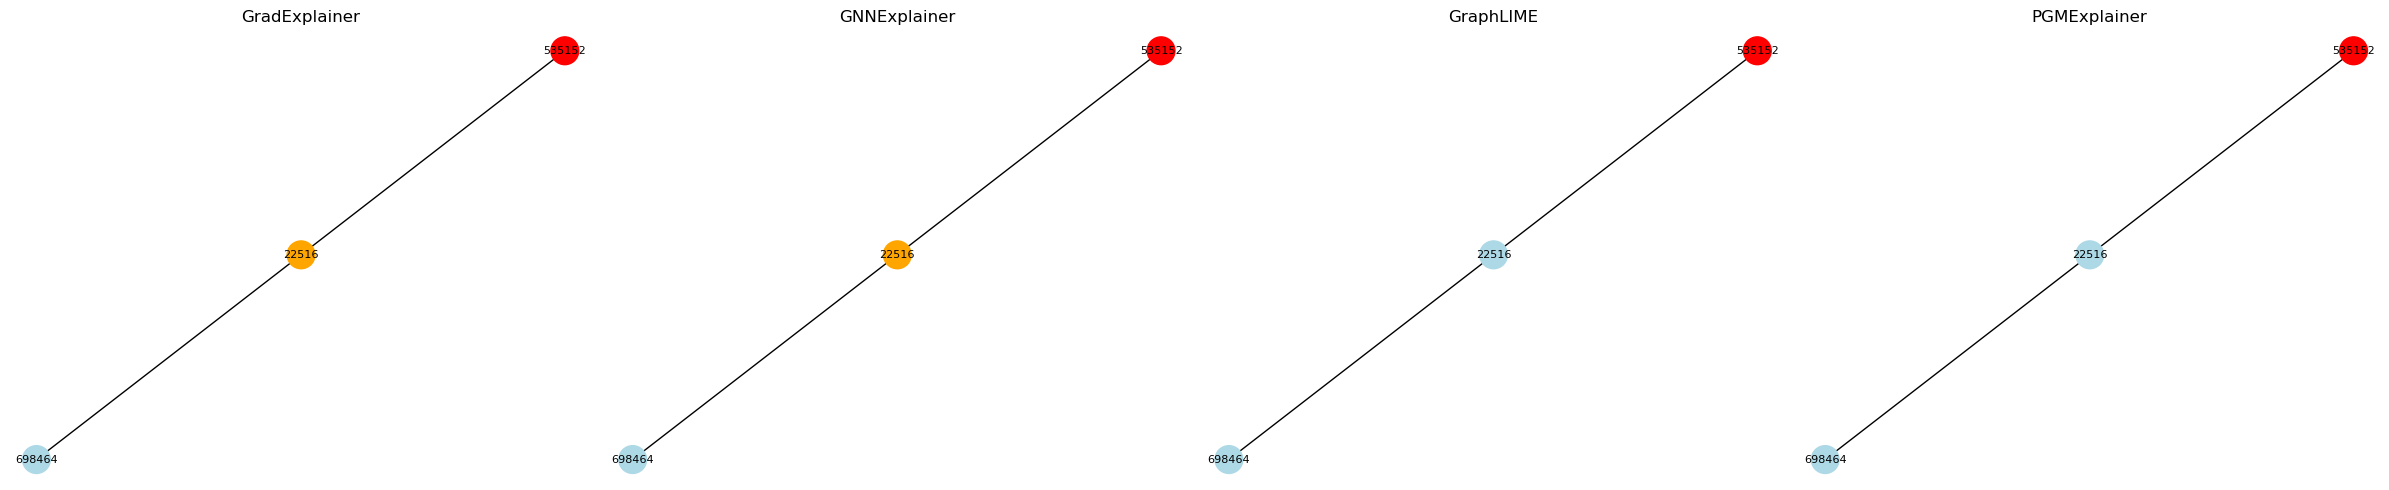

In [32]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import networkx as nx

def visualize_node_explanation(exp, graph_data, name: str, ax=None, num_hops=2):
    """
    Visualize explanation in a provided subplot axis (ax) or as new figure.

    Args:
        exp: Explanation object from GraphXAI (must contain node_idx and node_imp)
        graph_data: PyG Data(x, edge_index, y)
        name: Title of the plot
        ax: Matplotlib axis to draw on (optional)
        num_hops: Number of hops to show around the node
    """
    assert hasattr(exp, 'node_idx')
    assert hasattr(exp, 'enc_subgraph') and hasattr(exp.enc_subgraph, 'nodes')

    node_idx = exp.node_idx
    if isinstance(node_idx, torch.Tensor):
        node_idx = node_idx.item()

    G = nx.Graph()
    edge_index = graph_data.edge_index.cpu().numpy()
    for src, dst in zip(edge_index[0], edge_index[1]):
        G.add_edge(int(src), int(dst))

    try:
        neighbors = nx.single_source_shortest_path_length(G, node_idx, cutoff=num_hops).keys()
        subG = G.subgraph(neighbors).copy()
    except nx.NetworkXError:
        print(f"Node {node_idx} not found in graph.")
        return

    color_map = []
    node_imp = exp.node_imp if hasattr(exp, 'node_imp') else None
    for node in subG.nodes():
        if node == node_idx:
            color_map.append('red')
        elif node_imp is not None and node < len(node_imp) and node_imp[node] > 0:
            color_map.append('orange')
        else:
            color_map.append('lightblue')

    pos = nx.spring_layout(subG, seed=42)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    nx.draw(subG, pos, with_labels=True, node_color=color_map,
            node_size=400, font_size=8, ax=ax)
    ax.set_title(name)

# === Step 9: Visualize Explanations ===
graph_data_clean = Data(x=x, edge_index=data.edge_index, y=y)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))

for idx, (name, exp) in enumerate(full_explanations.items()):
    visualize_node_explanation(
        exp=exp,
        graph_data=graph_data_clean,
        name=name,
        ax=ax[idx]
    )

plt.tight_layout()
plt.savefig(f"explanation_imgs/all_explainers_node{node_to_explain}.png")
plt.show()

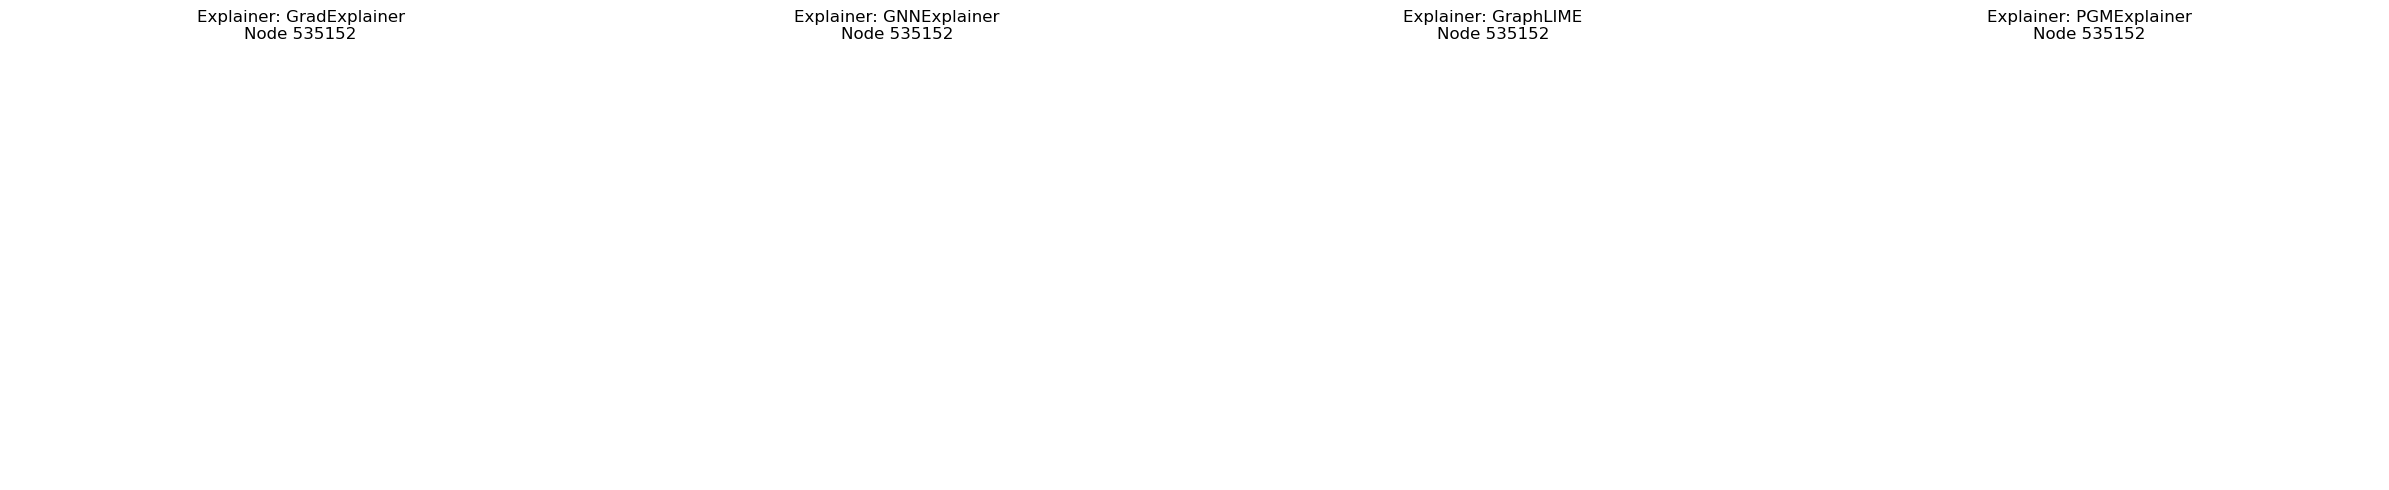

In [ ]:
# === PATCH: Safe visualize_node that handles int node_idx ===
from graphxai.utils.explanation import Explanation
import networkx as nx
from graphxai.utils import nx_conversion as gxai_utils

def visualize_node_fixed(self, num_hops, graph_data, ax=None, show_node_labels=True, **kwargs):
    wholeG = gxai_utils.to_networkx_conv(graph_data, to_undirected=True)
    kadd_hop_neighborhood = gxai_utils.khop_subgraph_nx(
        G=wholeG,
        num_hops=num_hops,
        node_idx=self.node_idx
    )
    subG = wholeG.subgraph(kadd_hop_neighborhood)
    pos = nx.spring_layout(subG, seed=42)

    # Warna berdasarkan importance
    color_map = []
    for node in subG.nodes():
        if hasattr(self, 'node_imp') and self.node_imp is not None and node < len(self.node_imp):
            if node == self.node_idx:
                color_map.append('red')
            elif self.node_imp[node] > 0:
                color_map.append('orange')
            else:
                color_map.append('lightblue')
        else:
            color_map.append('lightblue')

    nx.draw(subG, pos, with_labels=show_node_labels, node_color=color_map,
            node_size=400, font_size=8, ax=ax)

    if hasattr(self, 'node_idx'):
        if isinstance(self.node_idx, torch.Tensor):
            node_idx_int = self.node_idx.item()
        else:
            node_idx_int = self.node_idx
        ax.set_title(f"Explainer: {getattr(self, 'name', 'Unknown')}\nNode {node_idx_int}")

Explanation.visualize_node = visualize_node_fixed  # Patch method

import matplotlib.pyplot as plt
from torch_geometric.data import Data

# Buat graph_data_clean untuk visualisasi dari graph penuh
graph_data_clean = Data(x=x, edge_index=data.edge_index, y=y)

# Pastikan node_idx berbentuk int untuk semua explanation
for exp in full_explanations.values():
    if isinstance(exp.node_idx, torch.Tensor):
        exp.node_idx = exp.node_idx.item()

# Siapkan canvas subplot
fig, ax = plt.subplots(1, 4, figsize=(24, 5))

# Visualisasi GradExplainer
full_explanations['GradExplainer'].name = 'GradExplainer'
full_explanations['GradExplainer'].visualize_node(
    num_hops=2,
    graph_data=graph_data_clean,
    ax=ax[0],
    show_node_labels=True
)

# Visualisasi GNNExplainer
full_explanations['GNNExplainer'].name = 'GNNExplainer'
full_explanations['GNNExplainer'].visualize_node(
    num_hops=2,
    graph_data=graph_data_clean,
    ax=ax[1],
    show_node_labels=True
)

# Visualisasi GraphLIME
full_explanations['GraphLIME'].name = 'GraphLIME'
full_explanations['GraphLIME'].visualize_node(
    num_hops=2,
    graph_data=graph_data_clean,
    ax=ax[2],
    show_node_labels=True
)

# Visualisasi PGMExplainer
full_explanations['PGMExplainer'].name = 'PGMExplainer'
full_explanations['PGMExplainer'].visualize_node(
    num_hops=2,
    graph_data=graph_data_clean,
    ax=ax[3],
    show_node_labels=True
)

plt.tight_layout()
plt.savefig(f"explanation_imgs/all_explainers_node{node_to_explain}.png")
plt.show()
